# Ames Housing Price Prediction

by

- Ibra Lujumba <p>  2019/HD07/27842U
- Tindi Kester Bevin Batariganya <p> 2019/HD07/24822U
- Baker Lwasampijja <p> 2019/HD07/30567U

## Plan of action
- Exploratory Data Analysis (EDA)
- Data cleaning
- Missingness imputation
- Encoding categorical variables
- Outlier removal
- Feature engineering
- Scaling
- Cross-Validation with Hyperparameter tuning
- Modeling
- Deep Learning Techniques

The dataset used in this assignment is described by DeCock at [here](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt).

Before starting a project, it is important to have an empty environment. This means that no python objects are saved in memory.

In [1]:
%whos

Interactive namespace is empty.


In [2]:
import warnings
warnings.filterwarnings('ignore')

Importing libraries for manipulating arrays, dataframes and plotting the data. These libraries are Numpy (arrays), matplotlib and seaborn (plotting) as well as pandas (dataframes)

In [3]:
import numpy as np # manipulation of arrays
import pandas as pd # manipulating dataframes
import matplotlib.pyplot as plt # data visualisation
plt.style.use('ggplot')
import seaborn as sns # data visualisation,it is based on plt

Reading the data using pandas.read_csv function for comma seperated (.csv) files.

In [4]:
df_train = pd.read_csv('../housingPrices/train.csv')
df_test = pd.read_csv('../housingPrices/test.csv')

For the best perfomance and also to avoid redundancy in work, the datasets are combined such that the same transformations are applied to both datasets. The last column in the training data is removed since it is the target variable, the transformations are applied to the combined dataset.

The removed variable is assigned to a new variable (it will be needed later).


## Exploratory Data Analysis
This was aimed at trying to understand the structure of the data and features that it contains.
In this step, the extent of missingness of the data in the features is known and strategies for downstream analysis are made. Correlations between features, distributions of the features and data type of each feature.

In [5]:
# name of last column in training set
df_train.columns[-1] 

'SalePrice'

In [6]:
y_train=df_train.iloc[:,-1].values
df_train.drop(["SalePrice"],axis=1,inplace=True)
data=pd.concat([df_train,df_test])

The SalePrice column is analysed using the density plot to understand its distribution. The seaborn library has a consice way of doing this.

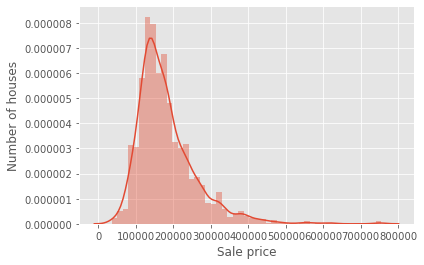

In [7]:
# density plot
ax = sns.distplot(y_train)
ax.set(xlabel = "Sale price", ylabel = "Number of houses")
plt.show()

Majority of the houses go for between 100,000 and 200,000 dollars. There is right skewedness which means that a small number of houses have a very high price. This suggests log transformation of the variable in order to have a normal distribution.

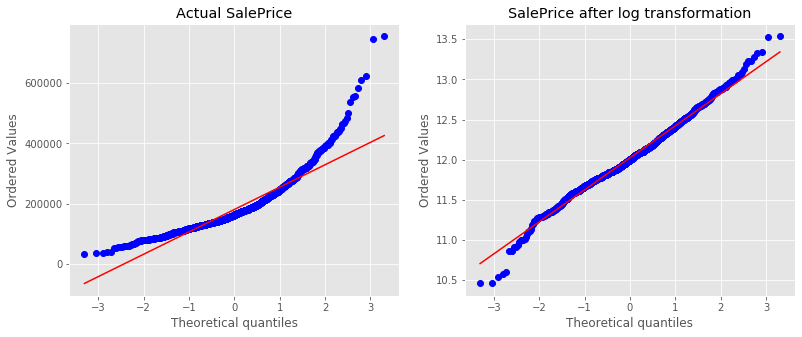

In [8]:
from scipy import stats
figure = plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
stats.probplot(y_train, plot = plt)
plt.title('Actual SalePrice')
plt.subplot(1,2,2)
ytrain_log = np.log(y_train)
stats.probplot(ytrain_log, plot = plt)
plt.title('SalePrice after log transformation')
plt.show()

The plot above is a QQ-plot. For normally distributed data, all values lies along the diagonal across the plot as in the second plot. The few point away from the diagonal are outliers in the data.

#### Checking the data types of variables in the dataframe <br/>
This is important because most algorithms in the scikit-learn expect numerical values. Any non-numeric values are encoded into numeric variables.

In [9]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-

There are 43 non-numeric variables (object(43)) and 37 numeric variables (float64(11) and int64(26)).

There are also columns with a lot of missing data such as PoolQC with 10 observed values. This means that most houses do not have a swimming pool. Other variables with a large proportion of missing data are MiscFeature, and Fence.

## Data cleaning

The impact of missing data on quantitative research can be serious, leading to biased estimates of parameters, loss of information, decreased statistical power, increased standard errors, and weakened generalizability of findings,[(Dong & Peng)](http://ncbi.nlm.nih.gov/pmc/articles/PMC3701793/).

In [10]:
notNA = data.count()/1460  # diving the number of observed non-missing values by the number of rows

for i in notNA:
    if i < 0.5: # less than 50% of observed data
        print("Proportion of non-missing data %5.4f at column %d" % (i, list(notNA).index(i)+1))

Proportion of non-missing data 0.1356 at column 7
Proportion of non-missing data 0.0068 at column 73
Proportion of non-missing data 0.3911 at column 74
Proportion of non-missing data 0.0719 at column 75


It can be seen that the 5th, 71th, 72th and 73th columns have more than 50% of the data missing. Rememebr pythonis zero-indexed.

Alternatively, the is.na() finction can be used. This function operates columnwise and returns a boolean dataframe of the same dimensions as the first one. The values can be summed up and the values divided by the number of observations which is the same. as finding the mean. Multiplying the value by 100 returns the percentage of missing values. (isna().sum()/len(df))

In [11]:
missing = data.isna().mean().round(5)*100

for i in missing:
    if i > 30: # setting threshold for missing data (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3701793/)
        print("Proportion of missing data:  %5.4f at column %d" % (i, list(missing).index(i)+1))

Proportion of missing data:  93.2170 at column 7
Proportion of missing data:  48.6470 at column 58
Proportion of missing data:  99.6570 at column 73
Proportion of missing data:  80.4390 at column 74
Proportion of missing data:  96.4030 at column 75


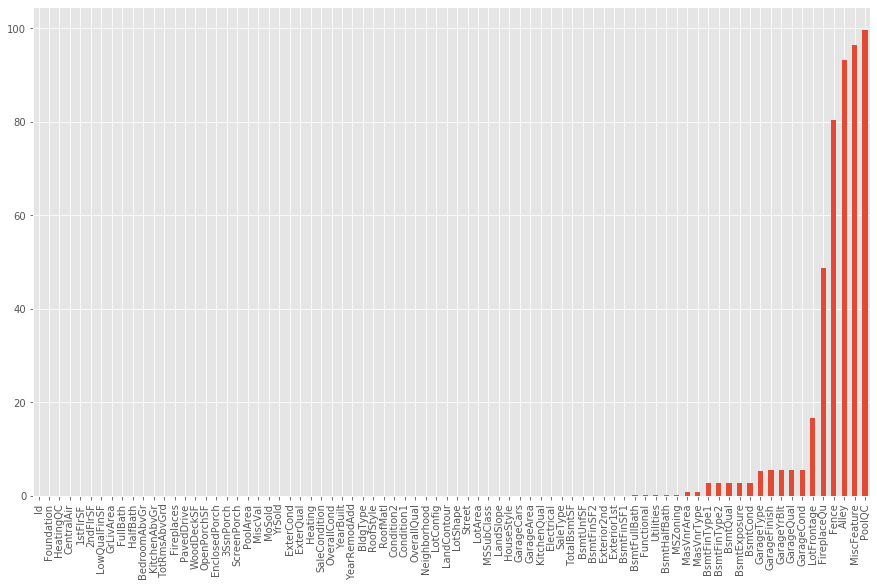

In [12]:
# visualisation using a bar plot
# Finding out the columns that are missing values in the dataset

missing.sort_values(inplace=True)
missing.plot.bar(figsize=(15,9), x = 'Features', y = 'Percentage of missing data')

All the features with non-zero values have missing values. However, Fence, Alley, MiscFeature and PoolQC have the largest number of missing values  with PoolQC having the largest value. 

In [13]:
data.columns[[6,57,72,73,74]] #python is zero-indexed

Index(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

The columns above will be removed/dropped. The criterion for dropping a feature was "Any feature with more than 30% of the data as missing". It is stringent but makes analysis easier as well as more accurate predictions since a large number of values are not imputed.

In [14]:
miss_features = missing.loc[missing>30].index
list(miss_features)

['FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC']

In [15]:
data.drop(miss_features,inplace=True,axis=1)

## Encoding categorical or non-numeric variables

Encoding methods available in python's sci-kit learn library are; 
- One Hot Encoding
- Label Encoding
- Ordinal Encoding
- Helmert Encoding
- Binary Encoding
- Frequency Encoding
- Mean Encoding
- Weight of Evidence Encoding
- Probability Ratio Encoding
- Hashing Encoding
- Backward Difference Encoding
- Leave One Out Encoding
- James-Stein Encoding
- M-estimator Encoding

A good description of when to use the above methods including the asociated precautions before using any is written by [Baijayanta Roy](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02), [Jeff Hale](https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159) and by [Florain Pargent](https://osf.io/356ed/download) in A Benchmark Experiment on How to Encode Categorical Features in Predictive Modeling.

It is necessary to tell apart nominal and ordinal variables as they require different encoding.

In [16]:
#getting a list of non-numeric columns

num_cols = list(data._get_numeric_data().columns) # getting numeric columns
cols = list(data.columns) # all the columns

cat_cols = [item for item in cols if item not in num_cols] # use set difference list(set(cols) - set(num_cols))
cat_cols

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [17]:
# identifying nominal, binary and ordinal variables using the dataset description
categorical = pd.DataFrame()
                           
for var in cat_cols:
    temp = [var, data[var].nunique(), (data[var].unique())]
    categorical = categorical.append(pd.Series(temp), ignore_index=True)

categorical.columns = ['feature','number of unique features','unique features']

In [18]:
categorical
categorical.style.set_properties(subset=['unique features'], **{'width': '300px'})

,feature,number of unique features,unique features
0,MSZoning,5,['RL' 'RM' 'C (all)' 'FV' 'RH' nan]
1,Street,2,['Pave' 'Grvl']
2,LotShape,4,['Reg' 'IR1' 'IR2' 'IR3']
3,LandContour,4,['Lvl' 'Bnk' 'Low' 'HLS']
4,Utilities,2,['AllPub' 'NoSeWa' nan]
5,LotConfig,5,['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
6,LandSlope,3,['Gtl' 'Mod' 'Sev']
7,Neighborhood,25,['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes' 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR' 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill' 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
8,Condition1,9,['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
9,Condition2,8,['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']


Nominal features (cannot be ordered) - LotConfig, Neighborhood, Condition1, Condition2, BldgType, HouseStyle,RoofStyle, RoofMatl, Exterior1st, Exterior2nd, Foundation, Heating, GarageType, MSZoning, LandContour, Street, CentralAir, SaleType, SaleCondition, MassVnrType

MSSubType is already encoded

Possible encoders - **Target encoding**

Ordinal variables (can be ordered) - LotShape, Utilities, LandSlope, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, HeatingQC, KitchenQual, Functional, FirePlaceQu, GarageFinish, GarageQual, GarageCond, BsmtFinType1, BsmtType2, Electrical, PavedDrive

Possible encoding - **Ordinal encoding**

OverallCond and OverallQual are ordinal variables but are already encoded

In [19]:
nominal = ['LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
           'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
           'Foundation', 'Heating', 'GarageType', 'MSZoning', 'LandContour', 
           'Street', 'CentralAir', 'SaleType', 'SaleCondition', 'MasVnrType']

ordinal = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 
           'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 
           'Functional', 'GarageFinish', 'GarageQual', 'GarageCond', 
           'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'PavedDrive']


Before encoding the non-numerical variables, it is important to identify features with high cardinality (those exhibiting a large number of levels). These have an non-productive effect in the case that decision trees are used in supervised learning. The number of splits done increases the computing power which may not be available.

In [20]:
# checking for cardinality (feature with a high number of levels)
sum(categorical['number of unique features']>=8)

8

In [21]:
# seperating categorical features
catColumns = data.select_dtypes(include=['object']).copy()
# print(catColumns.isnull().values.sum())
print(catColumns.isnull().mean())

MSZoning         0.001370
Street           0.000000
LotShape         0.000000
LandContour      0.000000
Utilities        0.000685
LotConfig        0.000000
LandSlope        0.000000
Neighborhood     0.000000
Condition1       0.000000
Condition2       0.000000
BldgType         0.000000
HouseStyle       0.000000
RoofStyle        0.000000
RoofMatl         0.000000
Exterior1st      0.000343
Exterior2nd      0.000343
MasVnrType       0.008222
ExterQual        0.000000
ExterCond        0.000000
Foundation       0.000000
BsmtQual         0.027749
BsmtCond         0.028092
BsmtExposure     0.028092
BsmtFinType1     0.027064
BsmtFinType2     0.027407
Heating          0.000000
HeatingQC        0.000000
CentralAir       0.000000
Electrical       0.000343
KitchenQual      0.000343
Functional       0.000685
GarageType       0.053786
GarageFinish     0.054471
GarageQual       0.054471
GarageCond       0.054471
PavedDrive       0.000000
SaleType         0.000343
SaleCondition    0.000000
dtype: float

In [22]:
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder

# for nomimal variables  https://medium.com/analytics-vidhya/types-of-categorical-data-encoding-schemes-a5bbeb4ba02b

# create an object of the OrdinalEncoding
ce_ordinal = ce.OrdinalEncoder(cols=nominal)
# fit and transform and you will get the encoded data
catColumns = ce_ordinal.fit_transform(catColumns)

 For ordinal variables, ordinal order  was assigned through through dictionaries.
 Variables considered are; LandSlope, ExtrQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, HeatingQC, KitchenQual, Functional, GarageFinish, GarageQual, GarageCond, SaleType. SaleCondition

In [23]:
LandSlope_dict = {'Gtl': 1,
                      'Med': 2,
                      'Sev': 3}
catColumns['LandSlope'] = catColumns.LandSlope.map(LandSlope_dict)

In [24]:
ExterQual_dict = {'Gd': 3,
                      'TA': 2,
                      'Ex': 4,
                     'Fa':1
                    }
catColumns['ExterQual'] = catColumns.ExterQual.map(ExterQual_dict)

In [25]:
LotShape_dict = {'Reg': 4,
                      'IR1': 3,
                      'IR2': 2,
                     'IR3':1
                    }
catColumns['LotShape'] = catColumns.LotShape.map(LotShape_dict)

In [26]:
Utilities_dict = {'AllPub': 4,
                      'NoSewr': 3,
                      'NoSewa': 2,
                     'ELO':1
                    }
catColumns['Utilities'] = catColumns.Utilities.map(Utilities_dict)

In [27]:
ExterQual_dict = {'Ex':5,
                  'Gd': 4,
                      'TA': 3,
                      'Fa': 2,
                     'Po':1
                    }
catColumns['ExterQual'] = catColumns.ExterQual.map(ExterQual_dict)

In [28]:
ExterCond_dict = {'Ex':5,
                  'Gd': 4,
                      'TA': 3,
                      'Fa': 2,
                     'Po':1
                    }
catColumns['ExterCond'] = catColumns.ExterCond.map(ExterCond_dict)

In [29]:
BsmtQual_dict = {'Ex':5,
                  'Gd': 4,
                      'TA': 3,
                      'Fa': 2,
                     'Po':1,
                  'NA':0
                    }
catColumns['BsmtQual'] = catColumns.BsmtQual.map(BsmtQual_dict)

In [30]:
BsmtCond_dict = {'Ex':5,
                  'Gd': 4,
                      'TA': 3,
                      'Fa': 2,
                     'Po':1,
                  'NA':0
                    }
catColumns['BsmtCond'] = catColumns.BsmtCond.map(BsmtCond_dict)

In [31]:
BsmtExposure_dict = {'Gd': 4,
                      'Av': 3,
                      'Mn': 2,
                     'No':1,
                  'NA':0
                    }
catColumns['BsmtExposure'] = catColumns.BsmtExposure.map(BsmtExposure_dict)

In [32]:
BsmtFinType1_dict = {'GLQ':6,
                 'ALQ':5,
                  'BLQ': 4,
                      'Rec': 3,
                      'LwQ': 2,
                     'Unf':1,
                  'NA':0
                    }
catColumns['BsmtFinType1'] = catColumns.BsmtFinType1.map(BsmtFinType1_dict)

In [33]:
BsmtFinType2_dict = {'GLQ':6,
                 'ALQ':5,
                  'BLQ': 4,
                      'Rec': 3,
                      'LwQ': 2,
                     'Unf':1,
                  'NA':0
                    }
catColumns['BsmtFinType2'] = catColumns.BsmtFinType2.map(BsmtFinType2_dict)

In [34]:
HeatingQC_dict = {'Ex':5,
                  'Gd': 4,
                      'TA': 3,
                      'Fa': 2,
                     'Po':1
                    }
catColumns['HeatingQC'] = catColumns.HeatingQC.map(HeatingQC_dict)

In [35]:
Electrical_dict = {'SBrkr':5,
                  'FuseA': 4,
                      'FuseF': 3,
                      'FuseP': 2,
                     'Mix':1
                    }
catColumns['Electrical'] = catColumns.Electrical.map(Electrical_dict)

In [36]:
KitchenQual_dict = {'Ex':5,
                  'Gd': 4,
                      'TA': 3,
                      'Fa': 2,
                     'Po':1
                    }
catColumns['KitchenQual'] = catColumns.KitchenQual.map(KitchenQual_dict)

In [37]:
Functional_dict = {'Typ':7,
                   'Min1':6,
                 'Min2':5,
                  'Mod': 4,
                      'Maj1': 3,
                      'Maj2': 2,
                     'Sev':1,
                  'Sal':0
                    }
catColumns['Functional'] = catColumns.Functional.map(Functional_dict)

In [38]:
GarageFinish_dict = {'Fin': 3,
                      'RFn': 2,
                      'Unf': 1,
                     'NA':0
                    }
catColumns['GarageFinish'] = catColumns.GarageFinish.map(GarageFinish_dict)

In [39]:
GarageQual_dict = {'Ex':5,
                  'Gd': 4,
                      'TA': 3,
                      'Fa': 2,
                     'Po':1,
                   'NA':0
                    }
catColumns['GarageQual'] = catColumns.GarageQual.map(GarageQual_dict)

In [40]:
GarageCond_dict = {'Ex':5,
                  'Gd': 4,
                      'TA': 3,
                      'Fa': 2,
                     'Po':1,
                   'NA':0
                    }
catColumns['GarageCond'] = catColumns.GarageCond.map(GarageCond_dict)

In [41]:
PavedDrive_dict = {'Y': 3,
                      'P': 2,
                     'N':1
                    }
catColumns['PavedDrive'] = catColumns.PavedDrive.map(PavedDrive_dict)

## Missingness Imputation

### Handling categorical columns
Since the number of missing values in the categorical variables is not large as per the criteria, missing values were imputed using the mode of the category.

In [42]:
for var in list(catColumns.columns):
    if catColumns[var].isnull().mean() > 0:
        catColumns = catColumns.fillna(catColumns[var].value_counts().index[0])

In [43]:
print(catColumns.isnull().mean() > 0) # no more missing values

MSZoning         False
Street           False
LotShape         False
LandContour      False
Utilities        False
LotConfig        False
LandSlope        False
Neighborhood     False
Condition1       False
Condition2       False
BldgType         False
HouseStyle       False
RoofStyle        False
RoofMatl         False
Exterior1st      False
Exterior2nd      False
MasVnrType       False
ExterQual        False
ExterCond        False
Foundation       False
BsmtQual         False
BsmtCond         False
BsmtExposure     False
BsmtFinType1     False
BsmtFinType2     False
Heating          False
HeatingQC        False
CentralAir       False
Electrical       False
KitchenQual      False
Functional       False
GarageType       False
GarageFinish     False
GarageQual       False
GarageCond       False
PavedDrive       False
SaleType         False
SaleCondition    False
dtype: bool


### Handling numeric columns


In [44]:
numColumns = data._get_numeric_data()

Proportion of missing data in numeric columns

In [45]:
numColumns.isna().sum()

Id                 0
MSSubClass         0
LotFrontage      486
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       2
BsmtHalfBath       2
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt      159
GarageCars         1
GarageArea         1
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
dtype: int64

LotFrontage and GarageYrBlt have the highest number of missing values. 

LotFrontage, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF and GarageArea will be imputed using the median or mean

GarageCars, BsmtFullBath, BsmtHalfBath will be imputed from most commonly occuring value

For missing values in GarageYrBuilt, these indicate absence of a garage and will be set to 0


In [46]:
numColumns.GarageYrBlt.fillna(0, inplace=True)

In [47]:
# filling with most commonly occuring value

discrete = ['BsmtFullBath', 'BsmtHalfBath', 'GarageCars']
for var in discrete:
    if numColumns[var].isnull().mean() > 0:
        numColumns = numColumns.fillna(numColumns[var].value_counts().index[0])

In [48]:
# filling with the median
numColumns.LotFrontage = data.groupby('Neighborhood')['LotFrontage'].\
                    transform(lambda x: x.fillna(x.median()))

In [49]:
numColumns.MasVnrArea = data.groupby('Neighborhood')['MasVnrArea'].\
                            transform(lambda x: x.fillna(x.median()))

numColumns.BsmtFinSF1 = data.groupby('Neighborhood')['BsmtFinSF1'].\
                            transform(lambda x: x.fillna(x.median()))

numColumns.BsmtFinSF2 = data.groupby('Neighborhood')['BsmtFinSF2'].\
                            transform(lambda x: x.fillna(x.median()))

numColumns.BsmtUnfSF = data.groupby('Neighborhood')['BsmtUnfSF'].\
                            transform(lambda x: x.fillna(x.median()))

In [50]:
numColumns.isna().mean() # more missing values

Id               0.0
MSSubClass       0.0
LotFrontage      0.0
LotArea          0.0
OverallQual      0.0
OverallCond      0.0
YearBuilt        0.0
YearRemodAdd     0.0
MasVnrArea       0.0
BsmtFinSF1       0.0
BsmtFinSF2       0.0
BsmtUnfSF        0.0
TotalBsmtSF      0.0
1stFlrSF         0.0
2ndFlrSF         0.0
LowQualFinSF     0.0
GrLivArea        0.0
BsmtFullBath     0.0
BsmtHalfBath     0.0
FullBath         0.0
HalfBath         0.0
BedroomAbvGr     0.0
KitchenAbvGr     0.0
TotRmsAbvGrd     0.0
Fireplaces       0.0
GarageYrBlt      0.0
GarageCars       0.0
GarageArea       0.0
WoodDeckSF       0.0
OpenPorchSF      0.0
EnclosedPorch    0.0
3SsnPorch        0.0
ScreenPorch      0.0
PoolArea         0.0
MiscVal          0.0
MoSold           0.0
YrSold           0.0
dtype: float64

## Further Exploratory data analysis on numeric columns

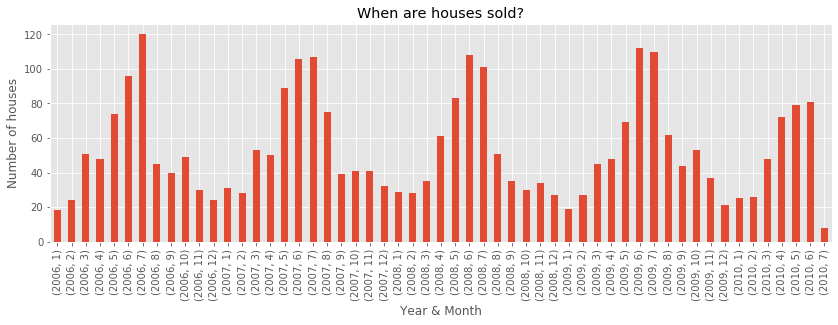

In [51]:
# looking at time-related variables (YearBuilt, YearRemodAdd, GarageYrBlt, MoSold, YrSold)

# When are houses sold?
data.groupby(['YrSold','MoSold']).Id.count().plot(kind='bar', figsize=(14,4))
plt.xlabel("Year & Month")
plt.ylabel("Number of houses")
plt.title('When are houses sold?')

plt.show()

Seasonal pattern for house sales. House sales peak mid-year each year.

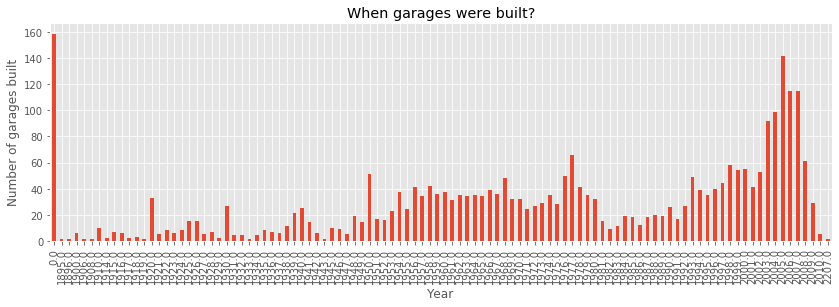

In [52]:
# When were garages built?
data.groupby(['GarageYrBlt']).Id.count().plot(kind='bar', figsize=(14,4))
plt.ylabel("Number of garages built")
plt.xlabel("Year")
plt.title('When garages were built?')
plt.show()

Garages became more common in the 2000's

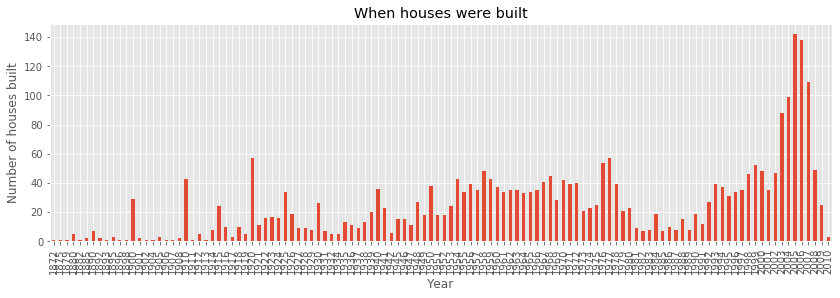

In [53]:
# When houses were built
data.groupby(['YearBuilt']).Id.count().plot(kind='bar', figsize=(14,4))
plt.title('When houses were built')
plt.ylabel("Number of houses built")
plt.xlabel("Year")
plt.show()

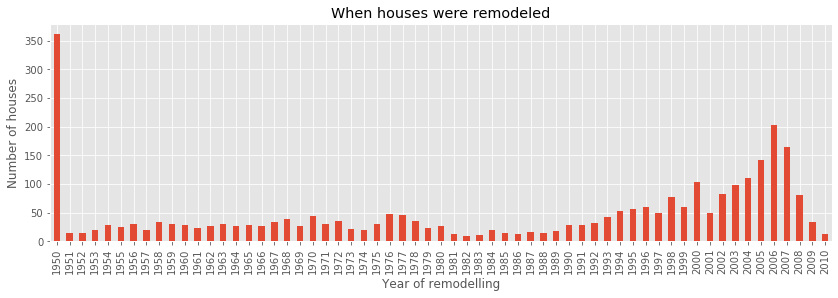

In [54]:
# When houses were remodelled
data.groupby(['YearRemodAdd']).Id.count().plot(kind='bar', figsize=(14,4))
plt.title('When houses were remodeled')
plt.ylabel("Number of houses")
plt.xlabel("Year of remodelling")
plt.show()

Most houses remodelled in the 50's

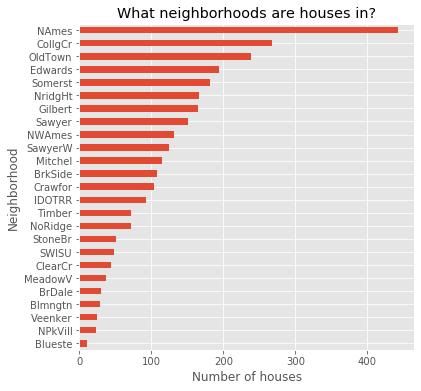

In [55]:
# Where are the houses?
data.groupby('Neighborhood').Id.count().\
    sort_values().\
    plot(kind='barh', figsize=(6,6))
plt.title('What neighborhoods are houses in?')
plt.xlabel("Number of houses")
plt.show()

## Generating new features

All are numeric. MoSold will be factorised since the euclidean distance between the numbers doesn't offer a lot of information

Difference between YearBuilt and YrSold is the age of the house when it was sold - HouseAge

In [56]:
# concatenating numColumns and catColumns
dataFull = pd.concat([numColumns, catColumns], axis=1, sort=False)

In [57]:
# checking that dataFull meets the expected dimensions and no missing values
dataFull.shape
dataFull.isna().sum().mean()

0.0

In [58]:
dataFull.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,5.0,4.0,7.0,1,2.0,3.0,3.0,3,1,1
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,5.0,3.0,7.0,1,2.0,3.0,3.0,3,1,1
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,5.0,4.0,7.0,1,2.0,3.0,3.0,3,1,1
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,5.0,4.0,7.0,2,1.0,3.0,3.0,3,1,2
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,5.0,4.0,7.0,1,2.0,3.0,3.0,3,1,1


Similar pattern to building of garages. More houses built with garages

Related features that can be summed up

TotalBath = BsmtFullBath + BsmtHalfBath + FullBath + HalfBAth

TotalFlrSF = 1stFlrSF + 2ndFlrSF + LowQualFinSF

TotalBsmtSF is assumed to relate BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF 

TotalRooms - TotRmsAbvGrd + TotalBath

HouseSF = GarageArea + WoodDeckSF + TotalBsmtSF + GrLivArea

TotalPorchSF = OpenPorchSF + EnclosedPorch + 3-SsnPorch + ScreenPorch

HouseAgeYr = YrSold - YearBuilt 

In [59]:
numNew = ['TotalBath', 'TotalFlrSF', 'TotalBsmtSF', 'TotalRooms', 'HouseSF', 'TotalPorchSF', 'HouseAgeYr']

In [60]:
#total number of baths
dataFull['TotalBath'] = dataFull['BsmtFullBath'] + (dataFull['BsmtHalfBath']*0.5) \
                            + dataFull['FullBath'] + (dataFull['HalfBath']*0.5)

#total floor square feet
dataFull['TotalFlrSF'] = dataFull['1stFlrSF'] + dataFull['2ndFlrSF'] + dataFull['LowQualFinSF']

#total number of rooms
dataFull['TotalRooms'] =  dataFull['TotRmsAbvGrd'] + dataFull['TotalBath']

#total size of the house in SF
dataFull['HouseSF'] = dataFull['GarageArea'] + dataFull['WoodDeckSF'] + dataFull['TotalBsmtSF']\
                    + dataFull['GrLivArea']

#total size of porches
dataFull['TotalPorchSF'] = dataFull['OpenPorchSF'] + dataFull['EnclosedPorch'] +\
                            dataFull['3SsnPorch'] + dataFull['ScreenPorch']

#age of the house
dataFull['HouseAgeYr'] = dataFull['YrSold'] - dataFull['YearBuilt']

Also creating features for factors that are taken into consideration during purchase of a house such as;
- is the house new or remodeled
- does it have a garage
- does it have a basement
- does it have a porch
- does it have a pool

In [61]:
dataFull['HasBasement'] = dataFull.TotalBsmtSF.apply(lambda x: 1 if x > 0 else 0)
dataFull['HasGarage'] = dataFull.GarageArea.apply(lambda x: 1 if x > 0 else 0)
dataFull['HasPorch'] = dataFull.TotalPorchSF.apply(lambda x: 1 if x > 0 else 0)
dataFull['HasPool'] = dataFull.PoolArea.apply(lambda x: 1 if x > 0 else 0)
dataFull['WasRemodeled'] = (dataFull.YearRemodAdd != dataFull.YearBuilt).astype(np.int64)
dataFull['IsNew'] = (dataFull.YearBuilt > 2000).astype(np.int64)
dataFull['WasCompleted'] = (dataFull.SaleCondition != 'Partial').astype(np.int64)


In [62]:
catNew = ['HasBasement','HasGarage', 'HasPorch', 'HasPool', 'WasRemodeled', 'IsNew', 'WasCompleted']

In [63]:
# resplitting the data
dF_train, dF_test = dataFull[0:1460], dataFull[1460:]

In [64]:
# joining dF_train to the target variable
dF_train = pd.concat([dF_train, pd.Series(y_train)], axis=1, sort=False)

In [65]:
dF_train.rename(columns={0:'SalePrice'}, inplace=True)

## More exploratory analysis to understand distribution of the data

In [66]:
dF_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,TotalPorchSF,HouseAgeYr,HasBasement,HasGarage,HasPorch,HasPool,WasRemodeled,IsNew,WasCompleted,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.0,1460.000000
mean,730.500000,56.897260,70.176370,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.339726,443.639726,...,87.084932,36.547945,0.974658,0.944521,0.686301,0.004795,0.476712,0.249315,1.0,180921.195890
std,421.610009,42.300571,22.433457,9981.264932,1.382997,1.112799,30.202904,20.645407,180.754082,456.098091,...,105.190364,30.250152,0.157217,0.228992,0.464154,0.069100,0.499629,0.432765,0.0,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,8.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,129975.000000
50%,730.500000,50.000000,70.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,48.000000,35.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,165.250000,712.250000,...,136.000000,54.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.0,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1027.000000,136.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,755000.000000


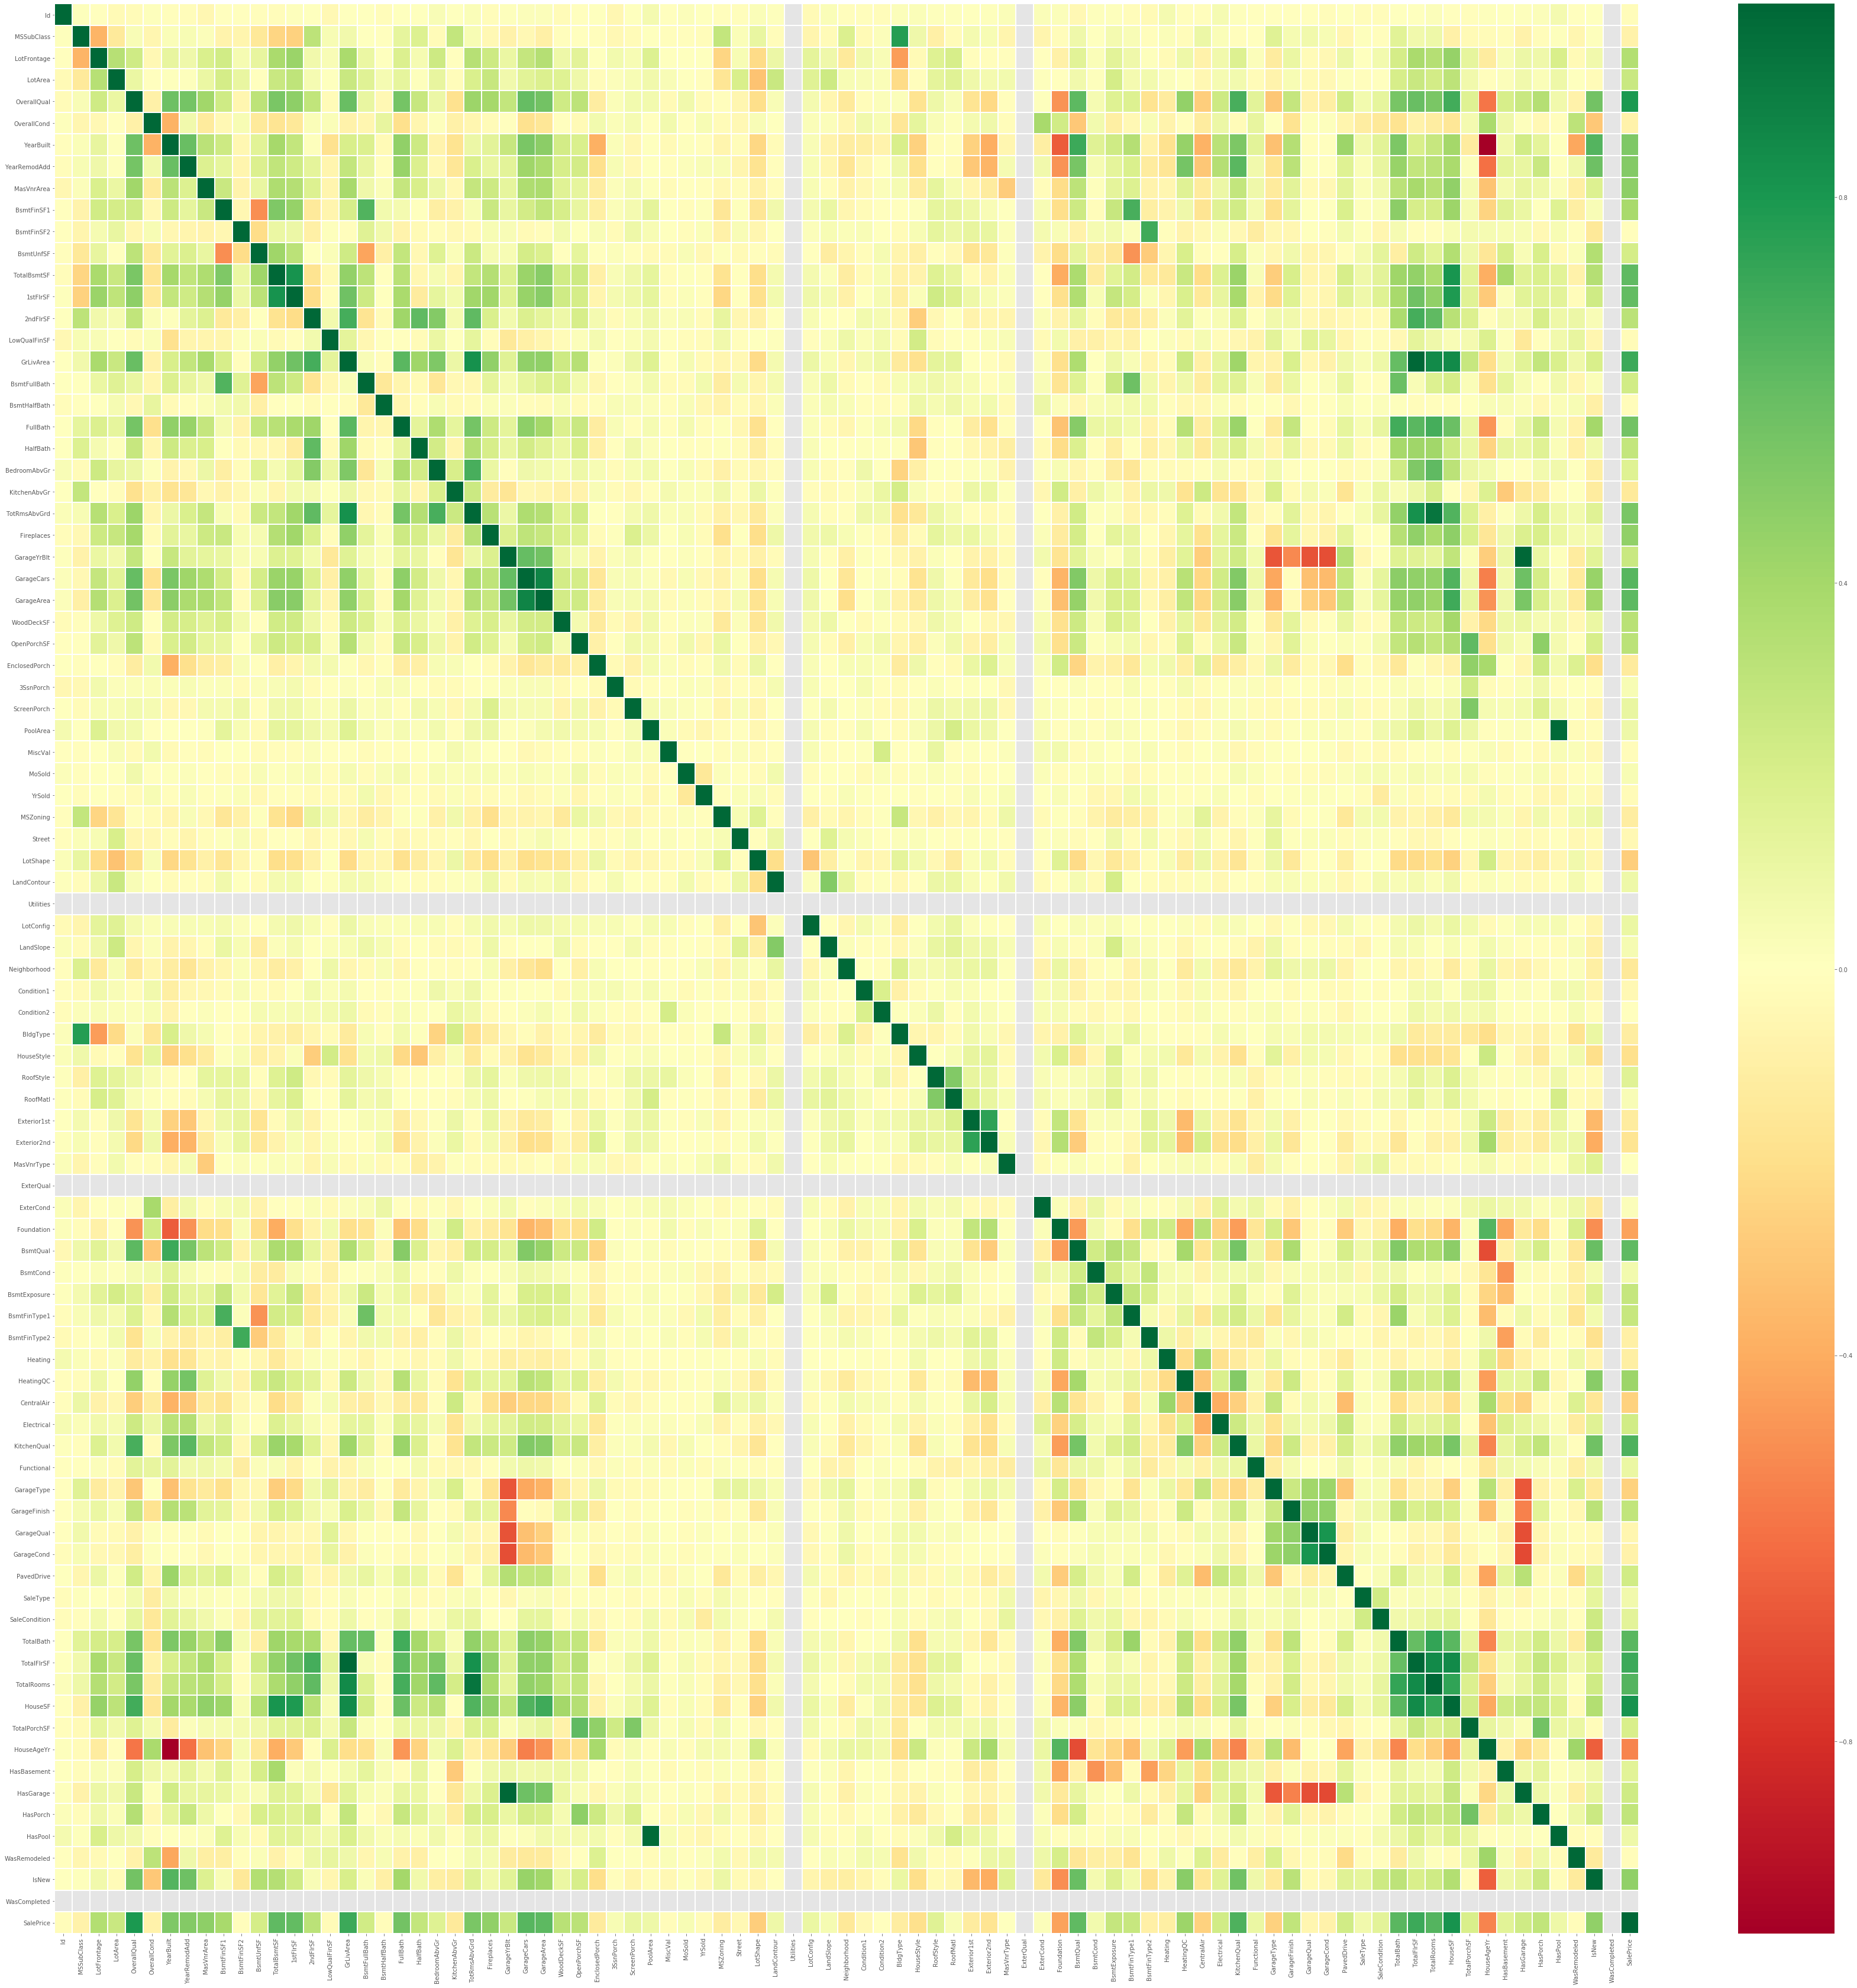

In [67]:
pearsoncorr = dF_train.corr(method='pearson')

# visualizing the correlation matrix as a heatmap
plt.figure(figsize=(60,60))
top_corr = pearsoncorr.index
sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdYlGn',
            annot=False,
            linewidth=1.0)

There features that are highly correlated with each other as well as with the target variable. (multicollinearity)

Also, there are features that are highly correlated with SalePrice. These are GrLivArea, OverallQual, TotalBsmtSF, 1stFlrSF, the new features (TotalBath, Total1stFlrSF, TotalRooms and HouseSF), as well as HouseAgeYr (highest negative correlation).

Medium correlated features are LotFrontage,LotArea, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, 

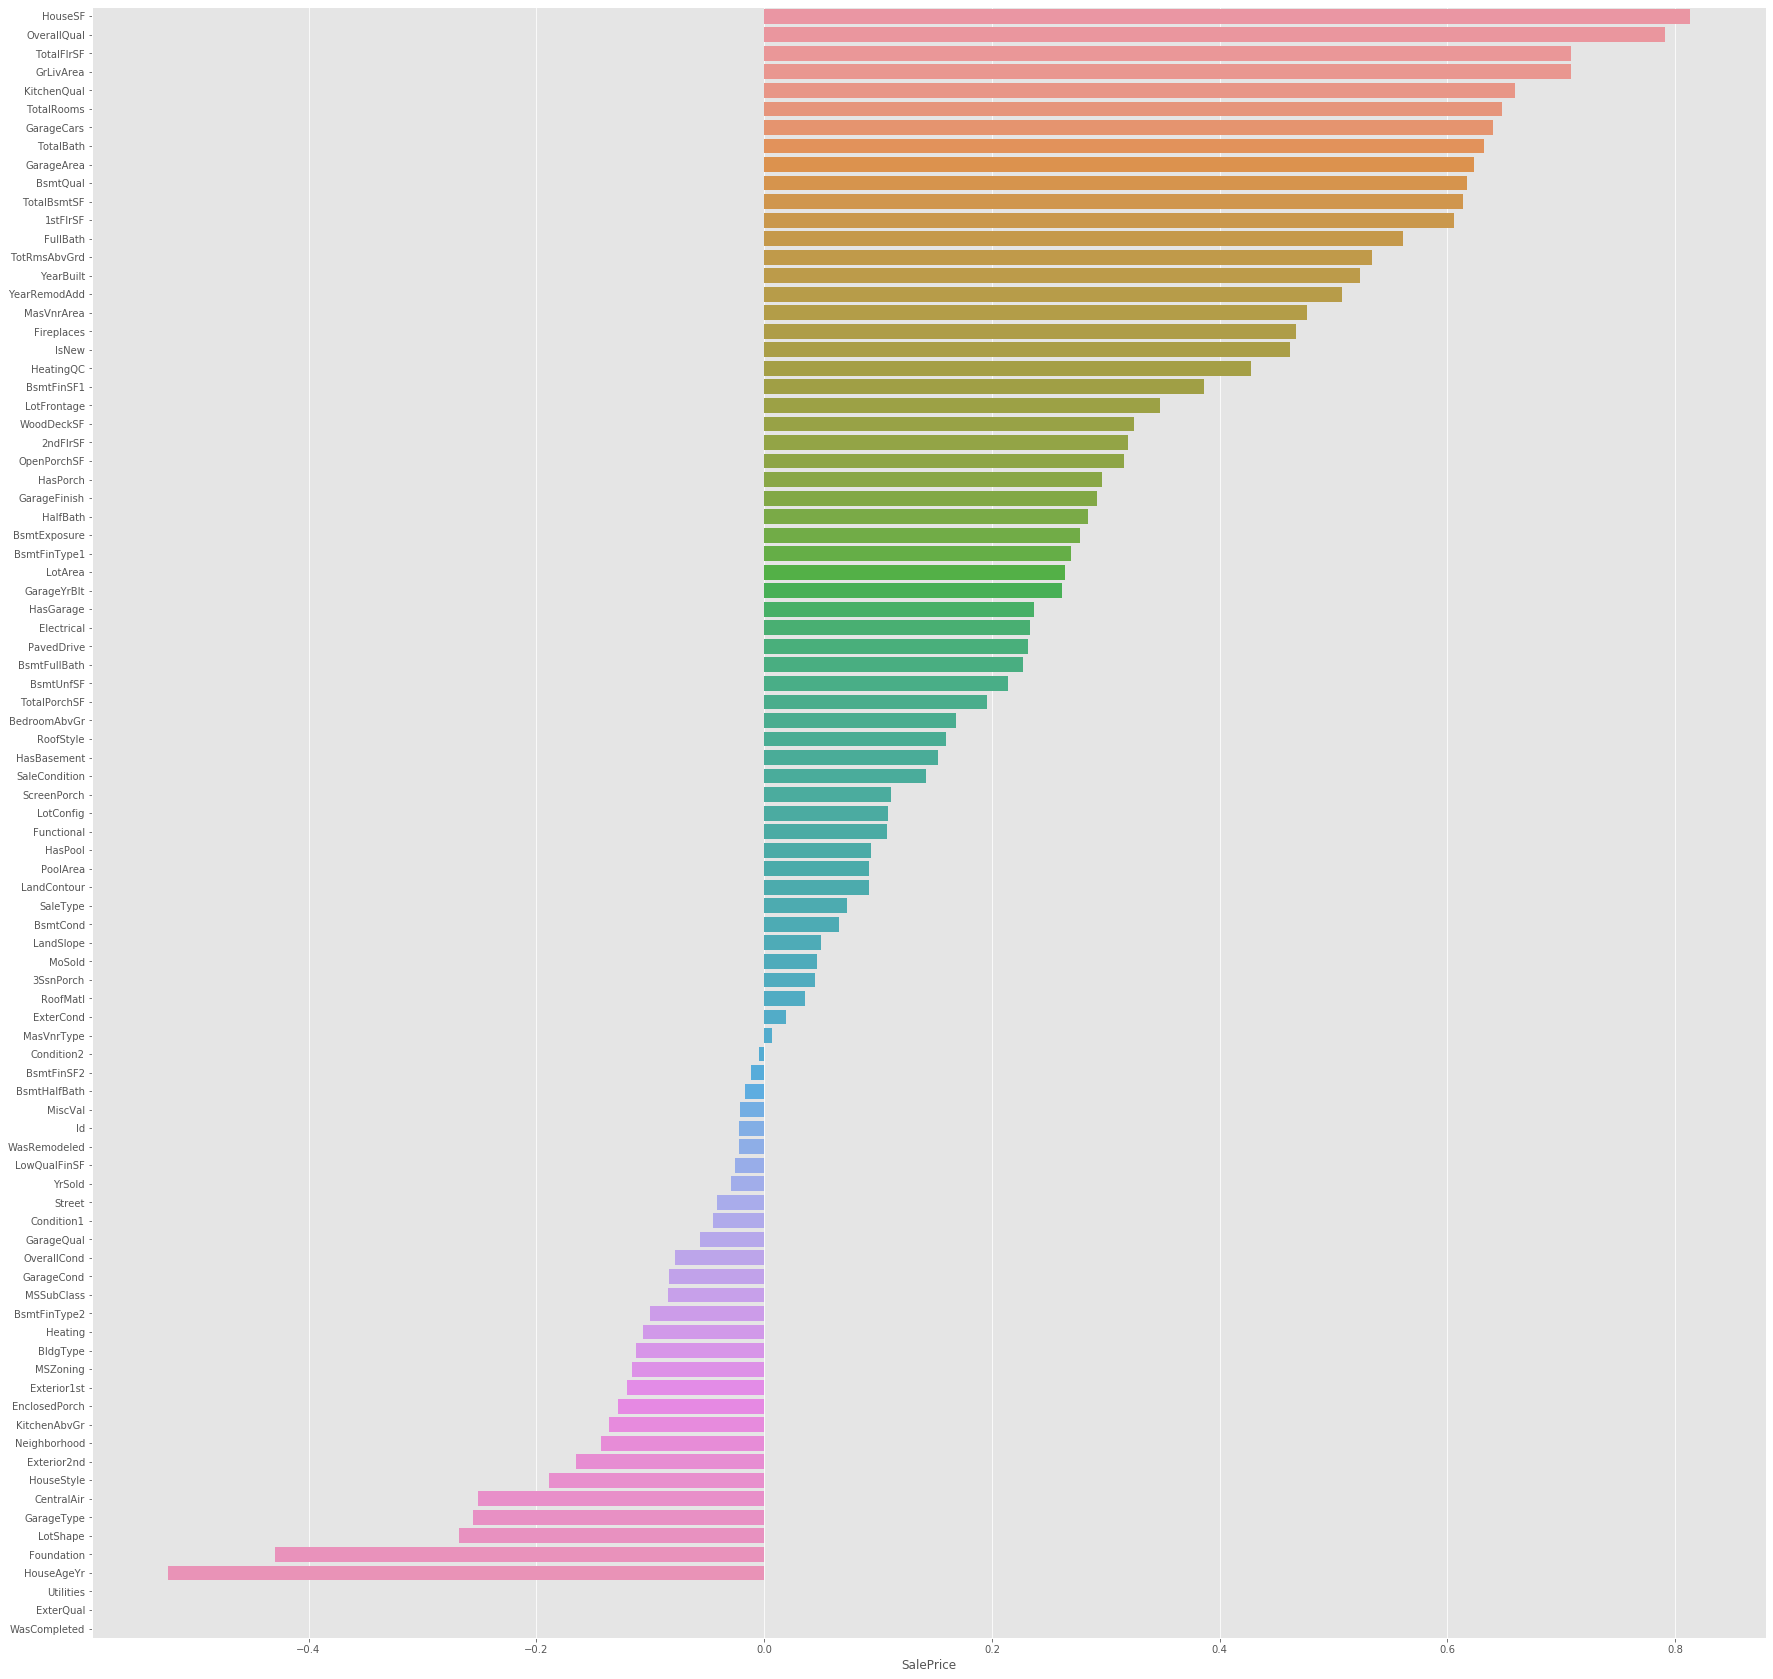

In [68]:
# Feature sorted by correlation to SalePrice

corr = pearsoncorr.sort_values('SalePrice', ascending=False)
plt.figure(figsize=(30,30))
sns.barplot( corr.SalePrice[1:], corr.index[1:], orient='h')
plt.show()

Generated features HouseAgeYr and HouseSF have the highest negative and positive correlation respectively.

Categorical and numerical variables are treated seperately

#### Categorical and discrete features

In [69]:
discrete = ['MoSold','YearBuilt','YearRemodAdd','YrSold','GarageYrBlt',
                                           'TotalBath', 'Fireplaces', 'BsmtFullBath', 'BsmtHalfBath',
                                           'FullBath', 'HalfBath', 'TotalRooms', 'MSSubClass','GarageCars',
                                           'TotRmsAbvGrd','BedroomAbvGr', 'HouseAgeYr', 'OverallCond','KitchenAbvGr']
catFeatures = catNew + nominal + ordinal + discrete
numFeatures = num_cols + numNew

In [70]:
numFeatures = list(set(numFeatures) - set(discrete))

In [71]:
total = catFeatures + numFeatures
df = list(dF_train.columns)

list(set(df) - set(total))

['SalePrice']

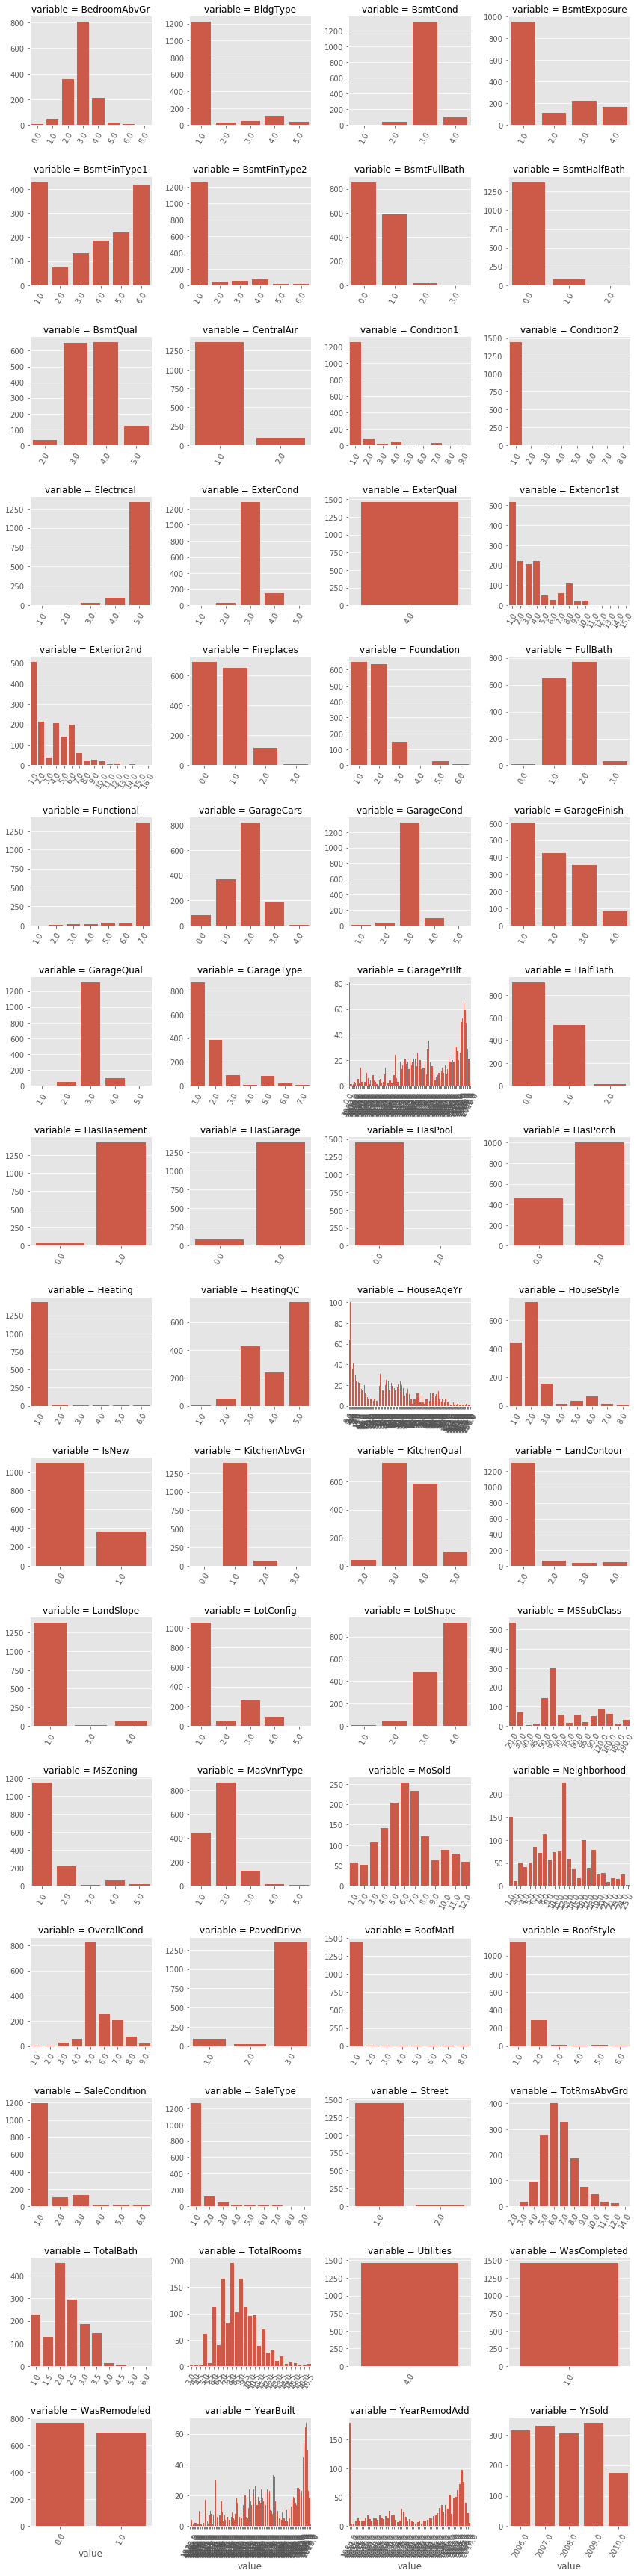

In [72]:
# Count plots of categorical & discrete features

f = pd.melt(dF_train, value_vars=sorted(catFeatures)) # similar to stack() function in R
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.countplot, 'value')
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

Noticeable features about houses in Ames are; most houses have three bedrooms, have no pool, were sold while new, have a porch and a basement. <br/>

The same information can be deduced from the boxplots below but the advantage of boxplots is that they let you see the outlying values and make judgements on how to remove them.

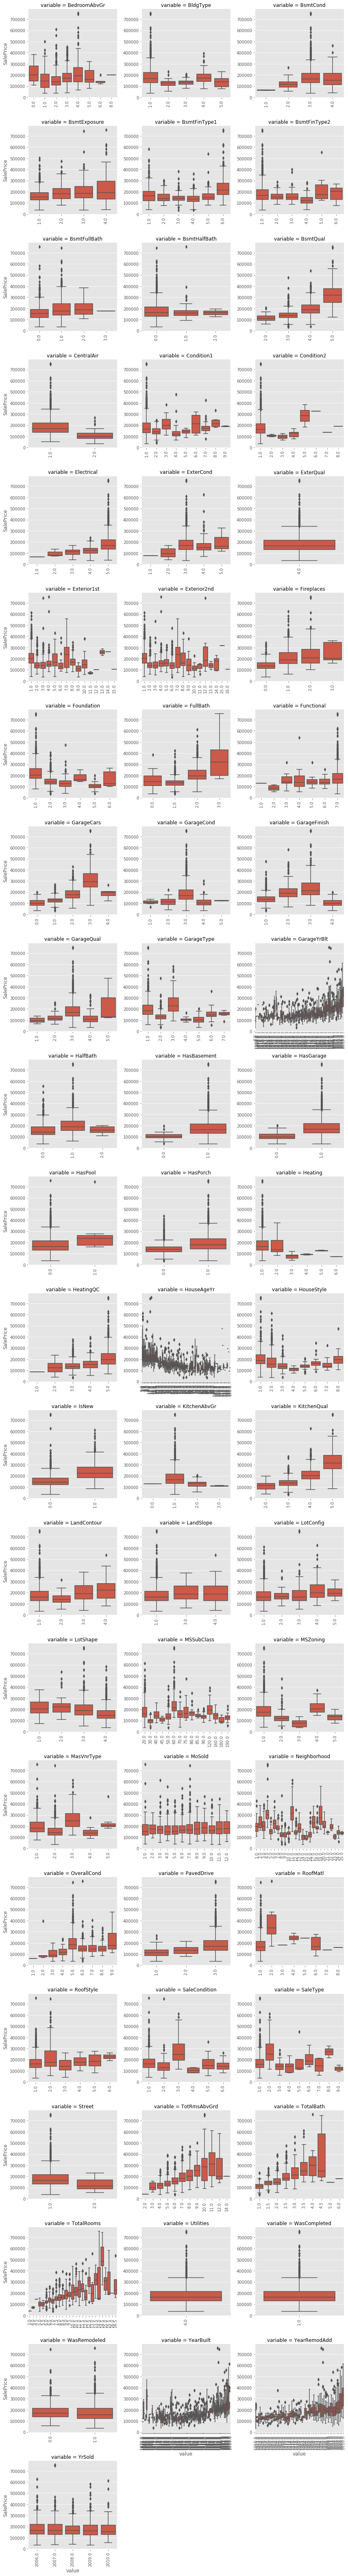

In [73]:
# Count plots of categorical features
f = pd.melt(dF_train, id_vars=['SalePrice'], value_vars=sorted(catFeatures))
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False, size=4)
g = g.map(sns.boxplot, 'value', 'SalePrice')
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

From the box plots, it can be seen that variables have outliers on the upper end of the SalePrice above 700,000.

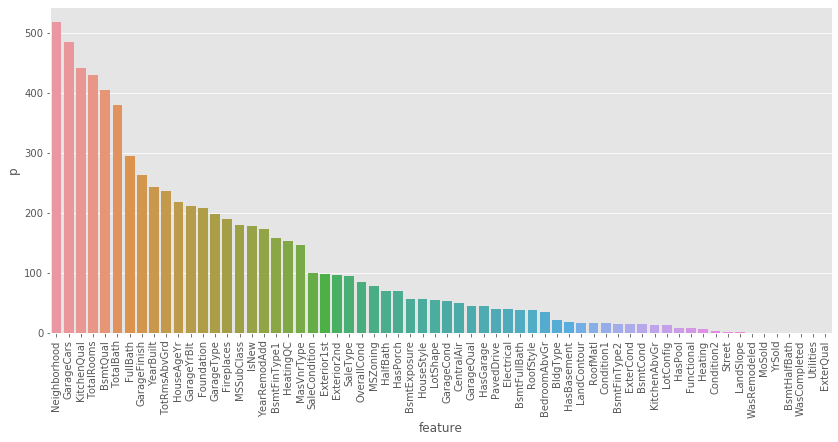

In [74]:
# which categorical feature contributes the most to predicting the SalePrice
import scipy.stats

anova = {'feature':[], 'f':[], 'p':[]}
for cat in catFeatures:
    group_prices = []
    for group in dF_train[cat].unique():
        group_prices.append(dF_train[dF_train[cat] == group]['SalePrice'].values)
    f, p = scipy.stats.f_oneway(*group_prices)
    anova['feature'].append(cat)
    anova['f'].append(f)
    anova['p'].append(p)
anova = pd.DataFrame(anova)
anova = anova[['feature','f','p']]
anova.sort_values('p', inplace=True)

# Plot
plt.figure(figsize=(14,6))
sns.barplot(anova.feature, np.log(1./anova['p']))
plt.xticks(rotation=90)
plt.show()

The categorical features on the left of the graph contribute the most to the value of the house. This importance decreases as onemoves to the right of the graph.

#### Continuous features

In [75]:
numFeatures = list(set(numFeatures) - set(['Id']))

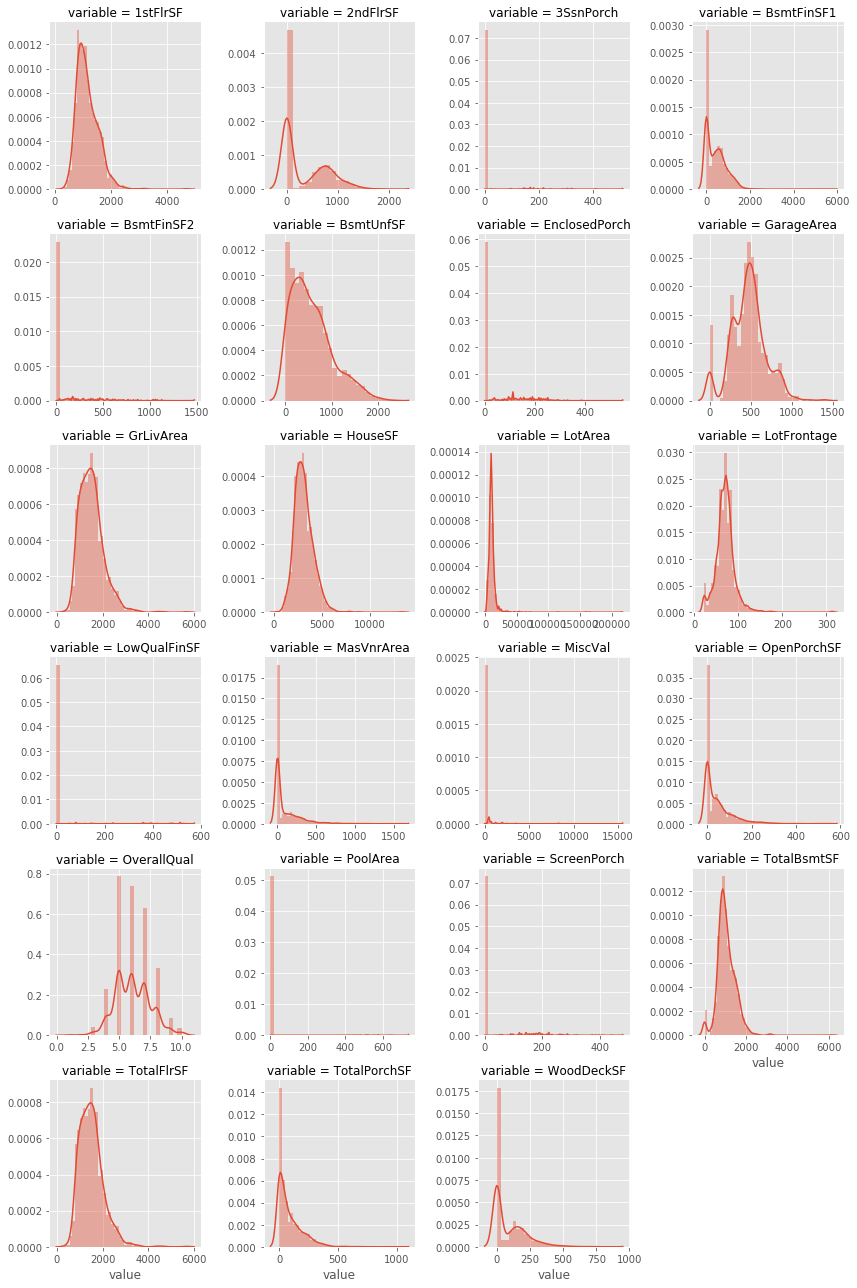

In [76]:
# Grid of distribution plots of all numerical features
f = pd.melt(dF_train, value_vars=sorted(numFeatures))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

# dF_train[numFeatures].plot(kind='density', subplots=True, layout=(6,4), figsize=(30,30))

The deduction that can be made from the above plots is that the features will be standardized using sci-kit's learn StandardScaler function to fit a normal distribution on the values of the features.

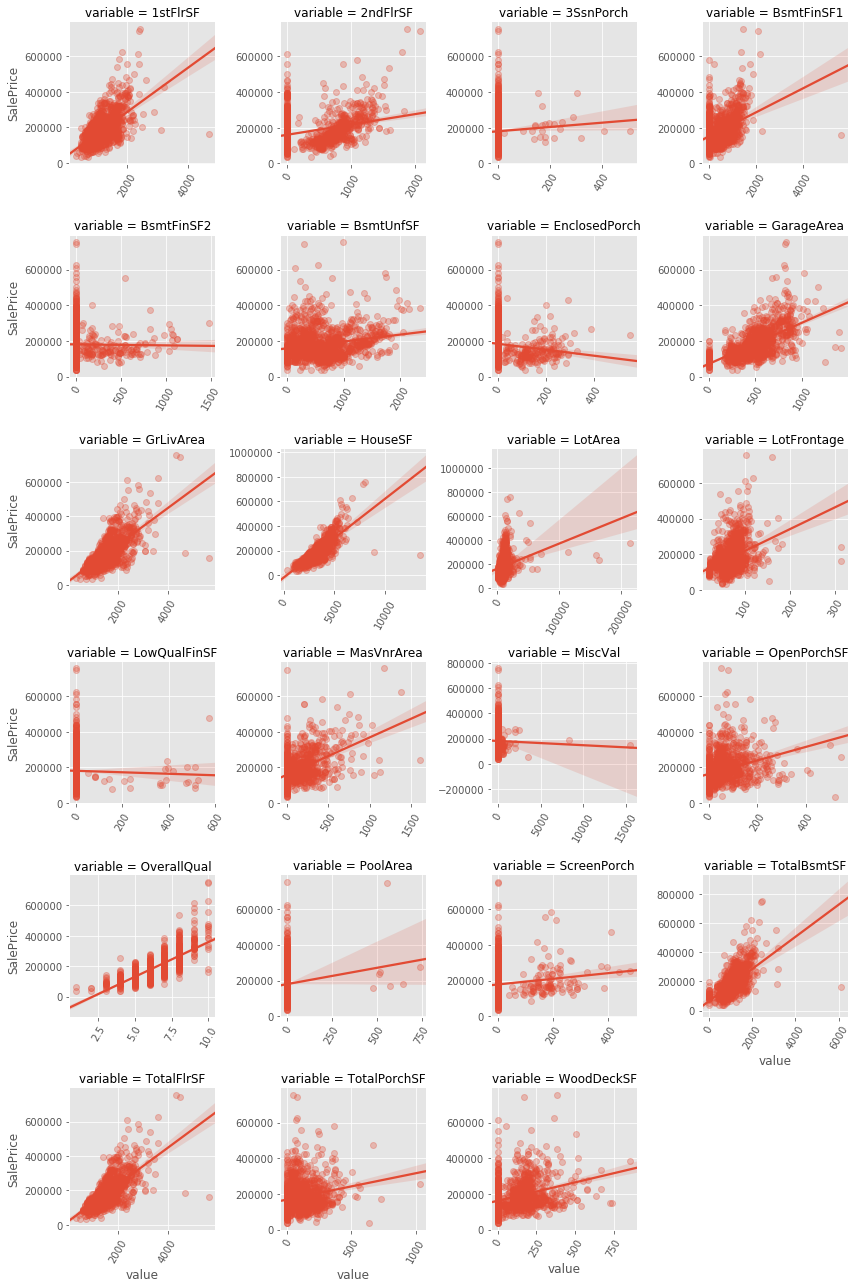

In [77]:
# Scatter plots of numerical features against SalePrice
f = pd.melt(dF_train, id_vars=['SalePrice'], value_vars=sorted(numFeatures))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.regplot, 'value', 'SalePrice', scatter_kws={'alpha':0.3})
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()


Scatter plots are used to visualise correlation of features with the target variable.
Scatter plots are also good for visualising outliers in the features. All features have outliers.

## Multivariate regression models, scaling and outlier removal <br/>

Since the number of features is very large, regression models wih regularisation will be used to avoid overfitting and making complex models.

Models to be used:
- Ridge regression
- LASSO regression
- Kernel ridge regression
- Stochastic gradient descent
- ElasticNet
- GradientBoostingRegressor
- RandomForestRegressor
- XGBoost
- LightGBM regressor
- Epsilon-Support Vector Regression

In [78]:
# dummy variables for nominal and categorical variables

# cat_dum = ['MSSubClass','OverallQual',
#        'OverallCond','MSZoning', 'Street', 'LotShape',
#        'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
#        'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
#        'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
#        'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
#        'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
#        'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish',
#        'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']

model_data = pd.get_dummies(dataFull)

# resplitting
model_train, model_test = model_data[0:1460], model_data[1460:]

In [79]:
# remove anything over 4,000 sq ft og GrLivArea
# model_train.drop(dF_train[dF_train.GrLivArea >= 4000].index, inplace=True)

In [80]:
# scaling numerical features

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
model_train.loc[:,numFeatures] = scaler.fit_transform(model_train[numFeatures])
model_test.loc[:,numFeatures] = scaler.fit_transform(model_test[numFeatures])

In [81]:
# splitting data into model_train into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = \
                    train_test_split(model_train, y_train, 
                                     test_size=0.3, random_state=42)

### Linear regression with cross validation
Linear regression performs the task to predict a dependent variable value (y) based on a given independent variable (x). So, this regression technique finds out a linear relationship between x (input) and y(output), The equation of the line is : $Y = mx + b$ where b is the intercept and m is the slope of the line.
This same concept can be extended to cases where there are more than two variables. This is called multiple linear regression. As in this case where you have to predict the price of the house based upon its area, number of bedrooms, the average income of the people in the area, the age of the house, and so on. In this case, the dependent variable(target variable) is dependent upon several independent variables. A regression model involving multiple variables can be represented as:
$y = b_0 + m_1b_1 + m_2b_2 + m_3b_3 + . . . m_nb_n$
This is the equation of a hyperplane. Remember, a linear regression model in two dimensions is a straight line; in three dimensions it is a plane, and in more than three dimensions, a hyperplane.

In [82]:
# multiple linear regression - least squares fitting
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
kfold = KFold(n_splits = 10, random_state = 42)
lm = LinearRegression()

# fitting the model
lm.fit(model_train, ytrain_log)
mse = cross_val_score(lm, model_train, y_train, scoring="neg_mean_squared_error",
                     cv=10)
mean_mse = np.mean(mse)

Cross-Predicted Accuracy: 0.8022556406050432


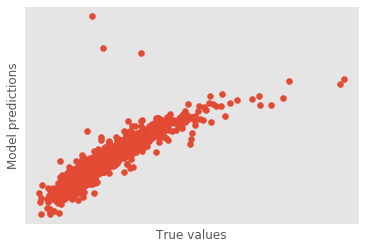

In [83]:
from sklearn import metrics

# Make cross validated predictions
lm_predictions = cross_val_predict(lm, model_train, y_train, cv=10)

plt.scatter(y_train, lm_predictions)


accuracy = metrics.r2_score(y_train, lm_predictions)
print('Cross-Predicted Accuracy:', accuracy)

plt.xticks(())
plt.yticks(())
plt.ylabel('Model predictions')
plt.xlabel('True values')

plt.show()

In [84]:
#predicting on new data and writing predictions to a file
y_predictions = lm.predict(model_test)
ypred_df = pd.concat([df_test.Id, pd.Series(y_predictions)], axis=1)
ypred_df.columns = ['Id','SalePrice']

ypred_df.to_csv('2d0.csv', index=False)

Ridge and Lasso regression are some of the simple techniques to reduce model complexity and prevent over-fitting which may result from simple linear regression.

In ridge regression, the cost function is altered by adding a penalty equivalent to square of the magnitude of the coefficients. This is equivalent to saying minimizing the cost function. The penalty term (lambda) regularizes the coefficients such that if the coefficients take large values the optimization function is penalized. So, ridge regression shrinks the coefficients and it helps to reduce the model complexity and multi-collinearity.

In lasso regression, the only difference with ridge regression is instead of taking the square of the coefficients, magnitudes are taken into account. This type of regularization (L1) can lead to zero coefficients i.e. some of the features are completely neglected for the evaluation of output. So Lasso regression not only helps in reducing over-fitting but it can help us in feature selection. Just like Ridge regression the regularization parameter (lambda) can be controlled.

### Ridge regression with regularisation


In [85]:
# ridge regression with cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
ridge = Ridge()

parameters = {'alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

ridge_regressor = GridSearchCV(ridge, parameters, scoring="neg_mean_squared_error",
                              cv=10)

ridge_regressor.fit(model_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [86]:
print(ridge_regressor.best_params_)

{'alpha': 0.01}


In [87]:
print(ridge_regressor.best_score_)

-1219446091.351903


Cross-Predicted Accuracy: 0.8561735050119437


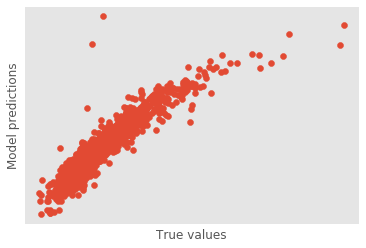

In [88]:
# Make cross validated predictions
r_predictions = ridge_regressor.predict(model_train,)

plt.scatter(y_train, r_predictions)


accuracy = metrics.r2_score(y_train, r_predictions)
print('Cross-Predicted Accuracy:', accuracy)

plt.xticks(())
plt.yticks(())
plt.ylabel('Model predictions')
plt.xlabel('True values')
plt.show()

In [89]:
#predicting on new data and writing predictions to a file
ridge_predictions = ridge_regressor.predict(model_test)

ridgepred_df = pd.concat([df_test.Id, pd.Series(ridge_predictions)], axis=1)
ridgepred_df.columns = ['Id','SalePrice']

ridgepred_df.to_csv('2d1.csv', index=False)

### Lasso regression

In [90]:
# lasso regression
from sklearn.linear_model import Lasso
lasso = Lasso()
parameters = {'alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring="neg_mean_squared_error",
                              cv=10)


lasso_regressor.fit(model_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [91]:
print(lasso_regressor.best_score_)
print(lasso_regressor.best_estimator_)

-1229466869.0803776
Lasso(alpha=20, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)


Cross-Predicted Accuracy: 0.8550419924752329


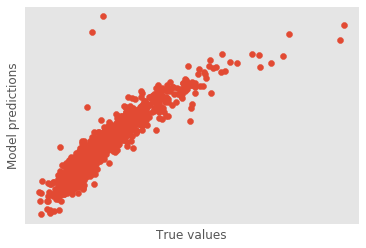

In [92]:
# Make cross validated predictions
l_predictions = lasso_regressor.predict(model_train)

plt.scatter(y_train, l_predictions)


accuracy = metrics.r2_score(y_train, l_predictions)
print('Cross-Predicted Accuracy:', accuracy)

plt.xticks(())
plt.yticks(())
plt.ylabel('Model predictions')
plt.xlabel('True values')
plt.show()

In [93]:
#predicting on new data and writing predictions to a file
lasso_predictions = lasso_regressor.predict(model_test)

lassopred_df = pd.concat([df_test.Id, pd.Series(lasso_predictions)], axis=1)
lassopred_df.columns = ['Id','SalePrice']

lassopred_df.to_csv('2d2.csv', index=False)

### Kernel ridge regression
Kernel ridge regression (KRR) combines Ridge regression and classification (linear least squares with l2-norm regularization) with the kernel trick. It thus learns a linear function in the space induced by the respective kernel and the data.

In [94]:
from sklearn.kernel_ridge import KernelRidge

kernel = KernelRidge()
parameters = {'alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

kernel_regressor = GridSearchCV(kernel, parameters, scoring="neg_mean_squared_error",
                              cv=10)


kernel_regressor.fit(model_train, y_train)

#predicting on new data and writing predictions to a file
kernel_predictions = kernel_regressor.predict(model_test)

kernelpred_df = pd.concat([df_test.Id, pd.Series(kernel_predictions)], axis=1)
kernelpred_df.columns = ['Id','SalePrice']

kernelpred_df.to_csv('2d3.csv', index=False)

Cross-Predicted Accuracy: 0.85617065302352


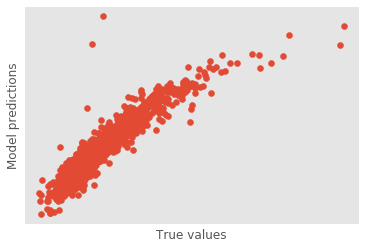

In [95]:
# Make cross validated predictions
kr_predictions = kernel_regressor.predict(model_train,)

plt.scatter(y_train, kr_predictions)


accuracy = metrics.r2_score(y_train, kr_predictions)
print('Cross-Predicted Accuracy:', accuracy)

plt.xticks(())
plt.yticks(())
plt.ylabel('Model predictions')
plt.xlabel('True values')
plt.show()

### Stochastic Gradient Descent Regressor


In [96]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor(max_iter=1000, tol=1e-3)

# fitting the model
kfold = KFold(n_splits = 10, random_state = 42)
sgd.fit(model_train, ytrain_log)
mse = cross_val_score(sgd, model_train, y_train, scoring="neg_mean_squared_error",
                     cv=10)
mean_mse = np.mean(mse)


#predicting on new data and writing predictions to a file
sgd_predictions = sgd.predict(model_test)
sgdpred_df = pd.concat([pd.DataFrame(df_test.Id), 
                        pd.DataFrame(sgd_predictions)], axis=1)
sgdpred_df.columns = ['Id','SalePrice']

sgdpred_df.to_csv('2d4.csv', index=False)

Cross-Predicted Accuracy: -6.349066268393717e+21


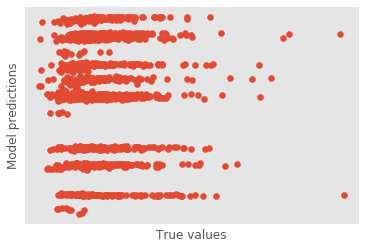

In [97]:
# Make cross validated predictions
sgd_predictions = cross_val_predict(sgd, model_train, y_train, cv=10)

plt.scatter(y_train, sgd_predictions)


accuracy = metrics.r2_score(y_train, sgd_predictions)
print('Cross-Predicted Accuracy:', accuracy)

plt.xticks(())
plt.yticks(())
plt.ylabel('Model predictions')
plt.xlabel('True values')
plt.show()

### ElasticNet with cross validation
Elastic Net which incorporates penalties from both L1 and L2 regularization. In addition to setting and choosing a lambda value elastic net also allows us to tune the alpha parameter where 𝞪 = 0 corresponds to ridge and 𝞪 = 1 to lasso. If alpha = 0 the penalty function reduces to the L1 (ridge) term and if  alpha = 1 we get the L2 (lasso) term. Therefore we can choose an alpha value between 0 and 1 to optimize the elastic net.

In [98]:
from sklearn.linear_model import ElasticNetCV
elastic = ElasticNetCV(cv=10, random_state=42)

elastic.fit(model_train, y_train)

#predicting on new data and writing predictions to a file
elastic_predictions = elastic.predict(model_test)
elasticpred_df = pd.concat([pd.DataFrame(df_test.Id), 
                            pd.DataFrame(elastic_predictions)], axis=1)
elasticpred_df.columns = ['Id','SalePrice']

#elasticpred_df.set_index(elasticpred_df.iloc[:,0])

elasticpred_df.to_csv('2d5.csv', index=False)

Cross-Predicted Accuracy: 0.14738373037123065


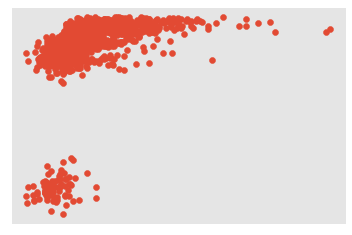

In [99]:
# Make cross validated predictions
el_predictions = elastic.predict(model_train)

plt.scatter(y_train, el_predictions)


accuracy = metrics.r2_score(y_train, el_predictions)
print('Cross-Predicted Accuracy:', accuracy)

plt.xticks(())
plt.yticks(())

plt.show()

In [100]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

Random Forests (RF) and Gradient Boosting Machine (GBM)are ensemble learning methods and predict (regression or classification) by combining the outputs from individual trees.<br/>

Gradient Boosting builds trees one at a time, where each new tree helps to correct errors made by previously trained tree. It performs the optimization in function space (rather than in parameter space) which makes the use of custom loss functions much easier.

- Strengths<br/>
    Since boosted trees are derived by optimizing an objective function, basically GBM can be used to solve almost all objective function that we can write gradient out. This including things like ranking and poission regression, which RF is harder to achieve.

- Weaknesses<br/>
    GBMs are more sensitive to overfitting if the data is noisy. Training generally takes longer because of the fact that trees are built sequentially. GBMs are harder to tune than RF. There are typically three parameters: number of trees, depth of trees and learning rate, and each tree built is generally shallow. <br/>


Random Forest train each tree independently, using a random sample of the data. This randomness helps to make the model more robust than a single decision tree, and less likely to overfit on the training data.
RF methods can handle a large amount of training data efficiently and are inherently suited for multi-class problems.

- Strengths<br/>
    RF is much easier to tune than GBM. There are typically two parameters in RF: number of trees and number of features to be selected at each node.
    RF is harder to overfit than GBM.

- Weaknesses<br/>
    The main limitation of the Random Forests algorithm is that a large number of trees may make the algorithm slow for real-time prediction.
    For data including categorical variables with different number of levels, random forests are biased in favor of those attributes with more levels. Therefore, the variable importance scores from random forest are not reliable for this type of data. Methods such as partial permutations were used to solve the problem 
    If the data contain groups of correlated features of similar relevance for the output, then smaller groups are favored over larger groups

### Gradient Boosting for regression.

In [101]:
# builds one tree at a time

gbr = GradientBoostingRegressor(loss='huber', 
                                random_state = 42)

param_grid = {'alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5],  
              'max_depth':[3,4],
              'n_estimators':[500],
              'max_features':['sqrt'],
              'min_samples_leaf':[5,10,15], 
              'min_samples_split':[6,8,10]}


gbr_regressor = GridSearchCV(estimator = gbr, param_grid = param_grid, scoring="neg_mean_squared_error",
                              cv=10)


gbr_regressor.fit(model_train, y_train)

#predicting on new data and writing predictions to a file
gbr_predictions = gbr_regressor.predict(model_test)

gbrpred_df = pd.concat([df_test.Id, pd.Series(gbr_predictions)], axis=1)
gbrpred_df.columns = ['Id','SalePrice']

gbrpred_df.to_csv('2d8.csv', index=False)

### A random forest regressor

In [102]:
rfr = RandomForestRegressor(criterion='mse', 
                                random_state = 42)

param_grid = {'max_depth':[3,4],
              'n_estimators':[500],
              'max_features':['sqrt'],
              'min_samples_leaf':[5,10,15], 
              'min_samples_split':[6,8,10]}


rfr_regressor = GridSearchCV(estimator = gbr, param_grid = param_grid, scoring="neg_mean_squared_error",
                              cv=10)


rfr_regressor.fit(model_train, y_train)

#predicting on new data and writing predictions to a file
rfr_predictions = rfr_regressor.predict(model_test)

rfrpred_df = pd.concat([df_test.Id, pd.Series(rfr_predictions)], axis=1)
rfrpred_df.columns = ['Id','SalePrice']

rfrpred_df.to_csv('2d9.csv', index=False)


### XGBoost
XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. XGBoost improves upon the base GBM framework through systems optimization and algorithmic enhancements.

**System Optimization:**
- Parallelization: <br/>
XGBoost approaches the process of sequential tree building using parallelized implementation. This is possible due to the interchangeable nature of loops used for building base learners; the outer loop that enumerates the leaf nodes of a tree, and the second inner loop that calculates the features. This nesting of loops limits parallelization because without completing the inner loop (more computationally demanding of the two), the outer loop cannot be started. Therefore, to improve run time, the order of loops is interchanged using initialization through a global scan of all instances and sorting using parallel threads. This switch improves algorithmic performance by offsetting any parallelization overheads in computation.<br/>

- Tree Pruning:<br/>
The stopping criterion for tree splitting within GBM framework is greedy in nature and depends on the negative loss criterion at the point of split. XGBoost uses ‘max_depth’ parameter as specified instead of criterion first, and starts pruning trees backward. This ‘depth-first’ approach improves computational performance significantly.<br/>

- Hardware Optimization: <br/>
This algorithm has been designed to make efficient use of hardware resources. This is accomplished by cache awareness by allocating internal buffers in each thread to store gradient statistics. Further enhancements such as ‘out-of-core’ computing optimize available disk space while handling big data-frames that do not fit into memory.<br/>

**Algorithmic Enhancements:**
- Regularization: <br/>
It penalizes more complex models through both LASSO (L1) and Ridge (L2) regularization to prevent overfitting.<br/>

- Sparsity Awareness: <br/>
XGBoost naturally admits sparse features for inputs by automatically ‘learning’ best missing value depending on training loss and handles different types of sparsity patterns in the data more efficiently.<br/>

- Weighted Quantile Sketch: <br/>
XGBoost employs the distributed weighted Quantile Sketch algorithm to effectively find the optimal split points among weighted datasets.<br/>

- Cross-validation: <br/>
The algorithm comes with built-in cross-validation method at each iteration, taking away the need to explicitly program this search and to specify the exact number of boosting iterations required in a single run.

In [103]:
xgbr = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                   min_child_weight=1.7817, n_estimators= 500, 
                   reg_alpha=0.4640, reg_lambda=0.8571, subsample=0.5213, silent=1,random_state =7, nthread = -1)

parameters = {'alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5],  'max_depth':[3,4]}


xgbr_regressor = GridSearchCV(xgbr, parameters, scoring="neg_mean_squared_error",
                              cv=10)


xgbr_regressor.fit(model_train, y_train)

#predicting on new data and writing predictions to a file
xgbr_predictions = xgbr_regressor.predict(model_test)

xgbrpred_df = pd.concat([df_test.Id, pd.Series(xgbr_predictions)], axis=1)
xgbrpred_df.columns = ['Id','SalePrice']

xgbrpred_df.to_csv('2d10.csv', index=False)

### LightGBM regressor

Light GBM is a gradient boosting framework that uses tree based learning algorithm that grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm. Light GBM is prefixed as ‘Light’ because of its high speed hence can handle the large size of data and takes lower memory to run. It focuses on accuracy of results and supports GPU learning.

In [104]:
lgbm = LGBMRegressor(objective='regression',n_estimators=720,
                     max_bin = 55, bagging_fraction = 0.8, bagging_freq = 5, feature_fraction = 0.2319,
                     feature_fraction_seed=9, bagging_seed=9, min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

parameters = {'alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5],  'max_depth':[3,4]}


lgbm_regressor = GridSearchCV(lgbm, parameters, scoring="neg_mean_squared_error",
                              cv=10)


lgbm_regressor.fit(model_train, y_train)

#predicting on new data and writing predictions to a file
lgbm_predictions = lgbm_regressor.predict(model_test)

lgbmpred_df = pd.concat([df_test.Id, pd.Series(lgbm_predictions)], axis=1)
lgbmpred_df.columns = ['Id','SalePrice']

lgbmpred_df.to_csv('2d11.csv', index=False)

### Epsilon-Support Vector Regression

Support vector regression (SVR) is a statistical method that examines the linear relationship between two continuous variables. In regression problems, we generally try to find a line that best fits the data provided. The equation of the line in its simplest form is described as below $y = mx +c$.
In the case of regression using a support vector machine, we define a small error value e (error = prediction - actual).
The value of e determines the width of the error tube (also called insensitive tube) and the number of support vectors, and a smaller e value indicates a lower tolerance for error.
Thus, we try to find the line’s best fit in such a way that: $(mx+c)-y ≤ e$ and  $y-(mx+c) ≤ e$

Error beloe $e$ are ignored. So in this case, only those data points that are outside the e error region will be contributing to the final cost calculation. SVM is memory efficient, which means it takes a relatively lower amount of calculation resources to train the model. This is because presenting the solution by means of a small subset of training points gives enormous computational advantages.
There are non-linear or complex relationships between features and labels. This is because we have the option to convert non-linear relationships to higher-dimensional problems in the case of support vector regression.

In [ ]:

svr = SVR(gamma=0.1)

# C is the regularisation parameter

parameters = {'C':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20],
             'kernel':['rbf', 'poly', 'linear']}

svr_regressor = GridSearchCV(svr, parameters, scoring="neg_mean_squared_error",
                              cv=10)


svr_regressor.fit(model_train, y_train)

#predicting on new data and writing predictions to a file
svr_predictions = svr_regressor.predict(model_test)

svrpred_df = pd.concat([df_test.Id, pd.Series(svr_predictions)], axis=1)
svrpred_df.columns = ['Id','SalePrice']

svrpred_df.to_csv('2d12.csv', index=False)

## Deep learning techinques

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Use some functions from tensorflow_docs
# !pip install -q git+https://github.com/tensorflow/docs

In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [ ]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# # instantiating the model in the strategy scope creates the model on the TPU

# with tpu_strategy.scope():
    
model = tf.keras.Sequential([layers.Dense(32, activation='relu', input_shape=(88,), 
                                          kernel_initializer='normal'),
                             layers.Dense(32, activation='relu'), 
                             layers.Dense(1, activation = 'linear')])

optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    
# for mean squared error regression problem
model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

In [ ]:
model.summary()

In [ ]:
# training the model
EPOCHS = 1000
history = model.fit(X_train, Y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])

In [ ]:
# visualising training process
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [Sale price]')

In [ ]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [sale price^2]')

In [ ]:
#  updating the model.fit call to automatically stop training when the validation score doesn't improve

# The patience parameter is the amount of epochs to check for improvement
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# early_history = model.fit(X_train, Y_train, 
#                     epochs=EPOCHS, validation_split = 0.2, verbose=0, 
#                     callbacks=[early_stop, tfdocs.modeling.EpochDots()])

In [ ]:
# making predictions
Y_predictions = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(Y_test, Y_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
# error distribution - expect normal distribution
error = Y_predictions - Y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [sale price]")
_ = plt.ylabel("Count")

In [ ]:
#predicting on new data and writing predictions to a file
tf_predictions = model.predict(model_test).flatten()

In [ ]:
tf_df = pd.concat([pd.DataFrame(df_test.Id), 
                            pd.DataFrame(tf_predictions)], axis=1)
elasticpred_df.columns = ['Id','SalePrice']

elasticpred_df.to_csv('2d6.csv', index=False)